### Libraries

In [1]:
import os
import h5py
import pandas as pd
from collections import deque
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn.metrics import mean_squared_errror, make_scorer

In [4]:
import sys
filepath = '/Users/Joe/Documents/Metis/Projects/metis-two-Luther/python-scripts'
sys.path.append(filepath)

In [5]:
from luther import nasdaq_companies
ticker_dict = nasdaq_companies('abbrev')

### Load Data

In [6]:
def load_df(filename):
    filepath = '/Users/Joe/Documents/Metis/Projects/metis-two-Luther/data/stock_wiki_trend_dataframes/'
    filepath = filepath + filename
    
    df = pd.read_hdf(filepath, 'table')
    return df    

In [7]:
def clean_data(df):
    df.dropna(inplace=True)
    df['search_interest'] = df['search_interest'].astype(int)
    df.rename(columns={'swing': 'percent_swing',
                       'percent_adj_change': 'adj_change'}, inplace=True)
    return df

In [8]:
filepath = '/Users/Joe/Documents/Metis/Projects/metis-two-Luther/data/stock_wiki_trend_dataframes/'
folder = [file for file in os.listdir(filepath) if file.startswith('.') == False]

### How much data do we have?

In [9]:
companies = deque()
for file in folder:
    abbrev = file.replace('.h5', '')
    df = load_df(file)
    df = clean_data(df)
    companies.append((abbrev, df.shape[0]))

In [10]:
companies = sorted(companies, key=lambda x: x[1], reverse=True)

In [11]:
num_rows = [x[1] for x in companies]

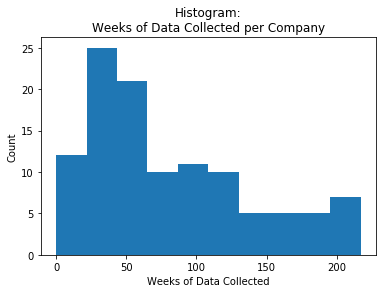

In [12]:
plt.hist(num_rows)
plt.xlabel('Weeks of Data Collected')
plt.ylabel('Count')
plt.title('Histogram:\nWeeks of Data Collected per Company');
plt.savefig("data_hist.pdf")

In [13]:
print(f"Collected data for {len(num_rows)} with a median of {int(np.median(num_rows))} weeks collected per company.")

Collected data for 111 with a median of 63 weeks collected per company.


In [14]:
for company in companies[0:10]:
    print(company)

('AMZN', 217)
('NFLX', 213)
('SBUX', 213)
('TSLA', 211)
('FB', 207)
('AAPL', 198)
('EA', 196)
('INTC', 194)
('CMCSA', 190)
('EBAY', 186)


### Company Specific
#### Starbucks and Tesla

In [15]:
sbux = clean_data(load_df('SBUX.h5'))
tsla = clean_data(load_df('TSLA.h5'))

In [16]:
def features(df):
    return df[['size_delta',
               'minor_edit',
               'non-minor_edit',
               'search_interest']]

In [17]:
sbux_features = features(sbux)
tsla_features = features(tsla)

In [18]:
sbux_target = sbux['adj_change']
tsla_target = tsla['adj_change']

Is it appropriate to be plotting my whole dataset, or should I only plot the training set as not to peak at the test set? There is clearly no correlation, so I think in this case it doesn't make a difference.

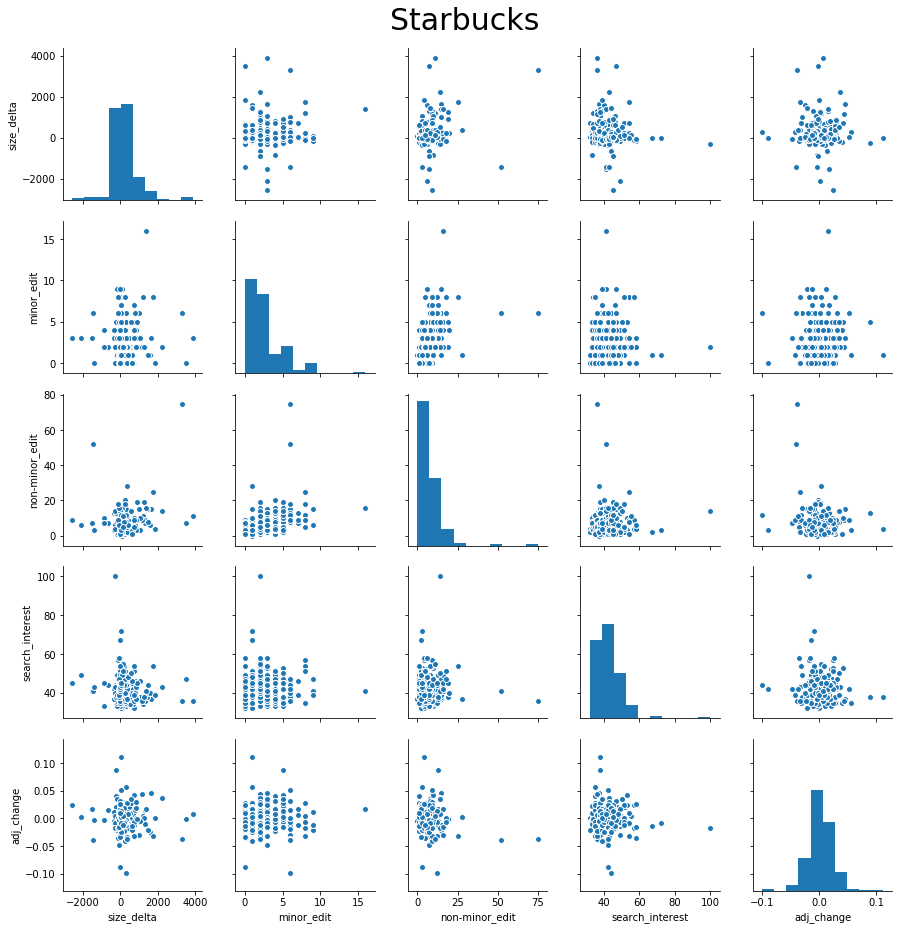

In [19]:
starbucks_pairplot = sbux_features.join(sbux_target)
sns.pairplot(starbucks_pairplot)
plt.suptitle("Starbucks", fontsize=30, y=1.03)
plt.savefig('starbucks_pairplot.pdf', bbox_inches='tight');

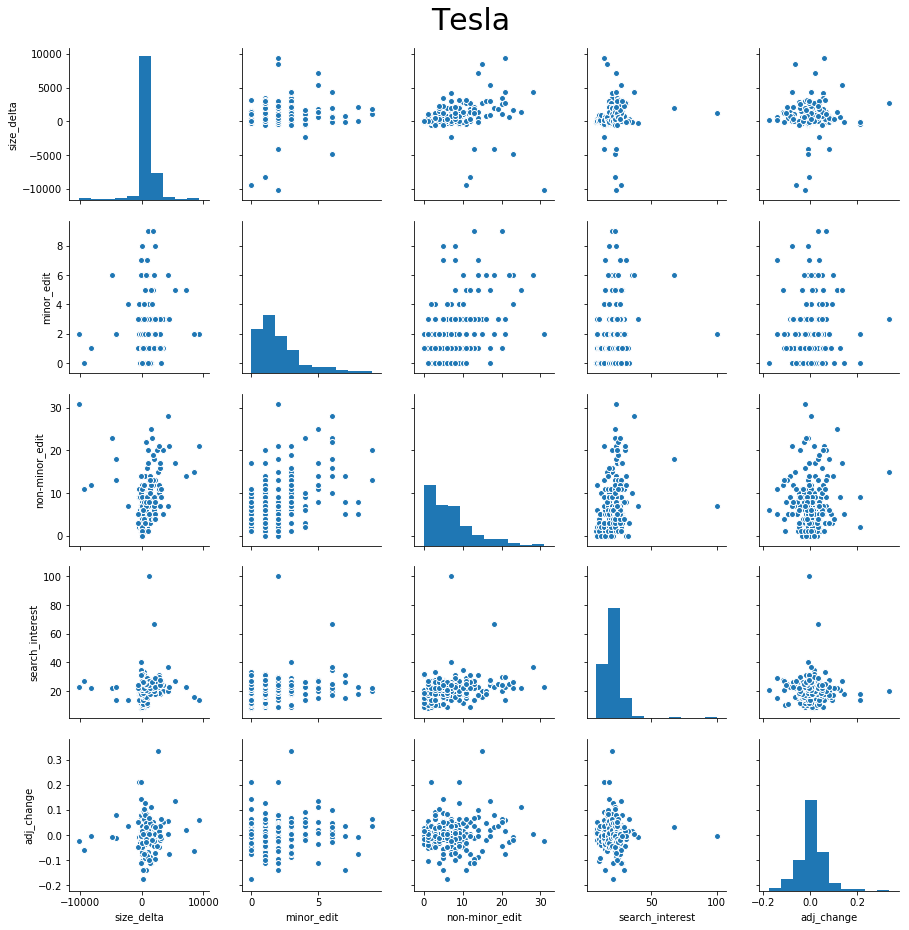

In [20]:
tesla_pairplot = tsla_features.join(tsla_target)
sns.pairplot(tesla_pairplot)
plt.suptitle("Tesla", fontsize=30, y=1.03);

#### Build a Model
First, split the data into train and test sets.

In [21]:
test_size, state = 0.25, 42

sbux_features_train, sbux_features_test, sbux_target_train, sbux_target_test = train_test_split(sbux_features,
                                                                                                sbux_target,
                                                                                                test_size = test_size,
                                                                                                random_state = state)
tsla_features_train, tsla_features_test, tsla_target_train, tsla_target_test = train_test_split(tsla_features,
                                                                                                tsla_target,
                                                                                                test_size = test_size,
                                                                                                random_state = state)

Standardize the data before regularization

In [22]:
ss_sbux = StandardScaler()
sbux_features_train = ss_sbux.fit_transform(sbux_features_train)
sbux_features_test  = ss_sbux.transform(sbux_features_test)

In [23]:
ss_tsla = StandardScaler()
tsla_features_train = ss_tsla.fit_transform(tsla_features_train)
tsla_features_test  = ss_tsla.transform(tsla_features_test)

In [85]:
def plot_errors(y_predict, y_actual, ax, label):
    ax.scatter(y_predict, y_actual, label=label)
    
    line_range = np.linspace(min(y_actual), max(y_actual), len(y_actual))
    ax.plot(line_range, line_range)
    
    #ax.legend()
    ax.set_title('Model Performance')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')

In [25]:
def plot_coefficients(model, ax, label):
    coeffs = [abs(coef) for coef in model.coef_]
    ax.plot(coeffs, marker = 'o', label=label)
    
    ax.set_title('Coefficients')
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Absolute Value')
    ax.legend()

In [83]:
def simple_linear_regression(title, features_train, target_train, features_test, target_test, savefile):
    model = LinearRegression()
    model.fit(features_train, target_train)
    score = model.score(features_test, target_test)
    
    fig, ax_rows = plt.subplots(2, 1, figsize=(7, 8))
    ax_left, ax_right = ax_rows
    plot_errors(model.predict(features_test), target_test, ax_left, 'R2: '+str(score))
    plot_coefficients(model, ax_right, 'R2: '+str(score))
    fig.suptitle(title, fontsize=20, y=1.05)
    
    plt.tight_layout(h_pad = 2.0)
    plt.savefig(savefile)

In [81]:
def plot_elastic_net(title, features_train, target_train, features_test, target_test, savefile):
    # Let's try three alphas
    fig, ax_rows = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(title, fontsize=20, y=1.02)

    alphas = [1e-3, 1e-2, 1e-1]
    L1_ratios = [0.25, 0.5, 0.75]
    for alpha, ax_row, ratio in zip(alphas, ax_rows, L1_ratios):
        ax_left, ax_right = ax_row

        model = ElasticNet(alpha=alpha, l1_ratio=ratio)
        model.fit(features_train, target_train)
        score = model.score(features_test, target_test)
        print(score)

        plot_errors(model.predict(features_test), target_test, ax_left, 'Alpha: '+str(alpha))
        plot_coefficients(model, ax_right, 'L1 Ratio: '+str(ratio))
    
    plt.tight_layout()
    plt.savefig(savefile, bbox_inches='tight')

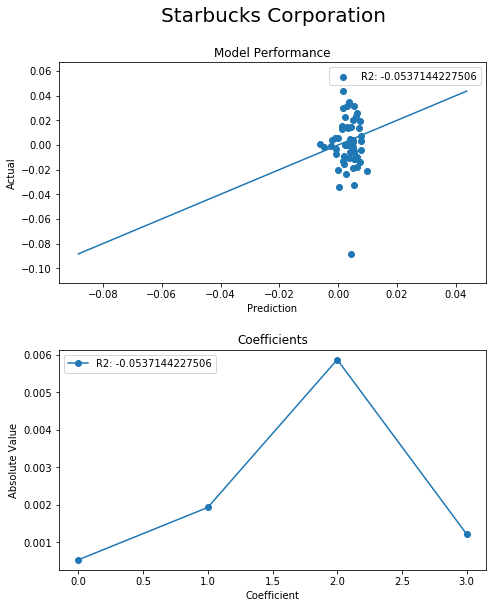

In [84]:
simple_linear_regression('        ' + ticker_dict['SBUX'],
                         sbux_features_train, sbux_target_train,
                         sbux_features_test, sbux_target_test,
                         'starbucks_simple_regression.pdf')

-0.0511713232527
-0.0142644358907
-0.0131951140136


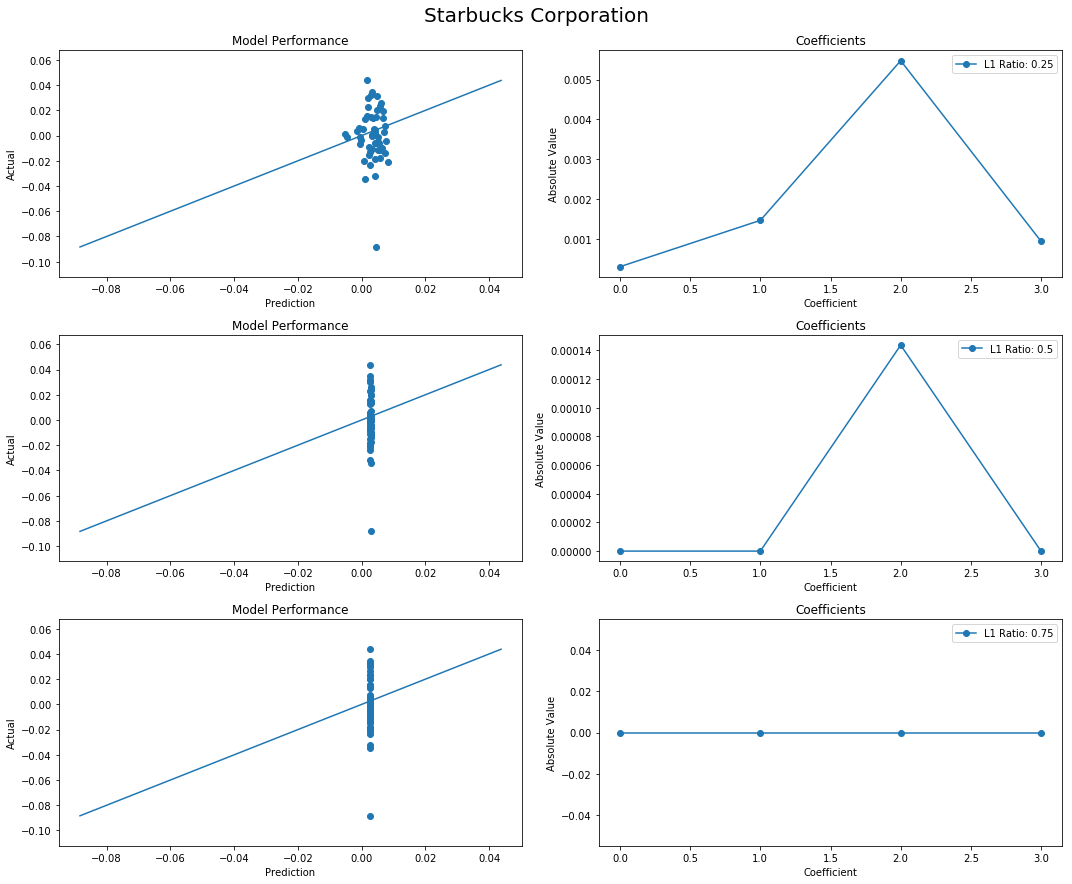

In [86]:
plot_elastic_net(ticker_dict['SBUX'],
                 sbux_features_train, sbux_target_train,
                 sbux_features_test, sbux_target_test,
                 'starbucks_elastic_net.pdf')

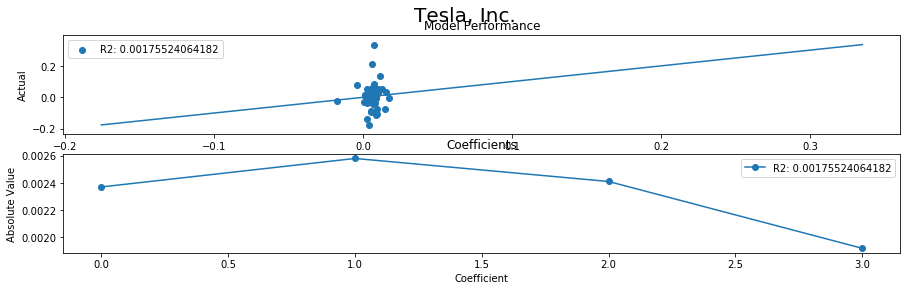

In [30]:
simple_linear_regression(ticker_dict['TSLA'],
                         tsla_features_train, tsla_target_train,
                         tsla_features_test, tsla_target_test,
                         'tesla_linear_regression.pdf')

0.00231078449811
-0.00277140569906
-0.00277140569906


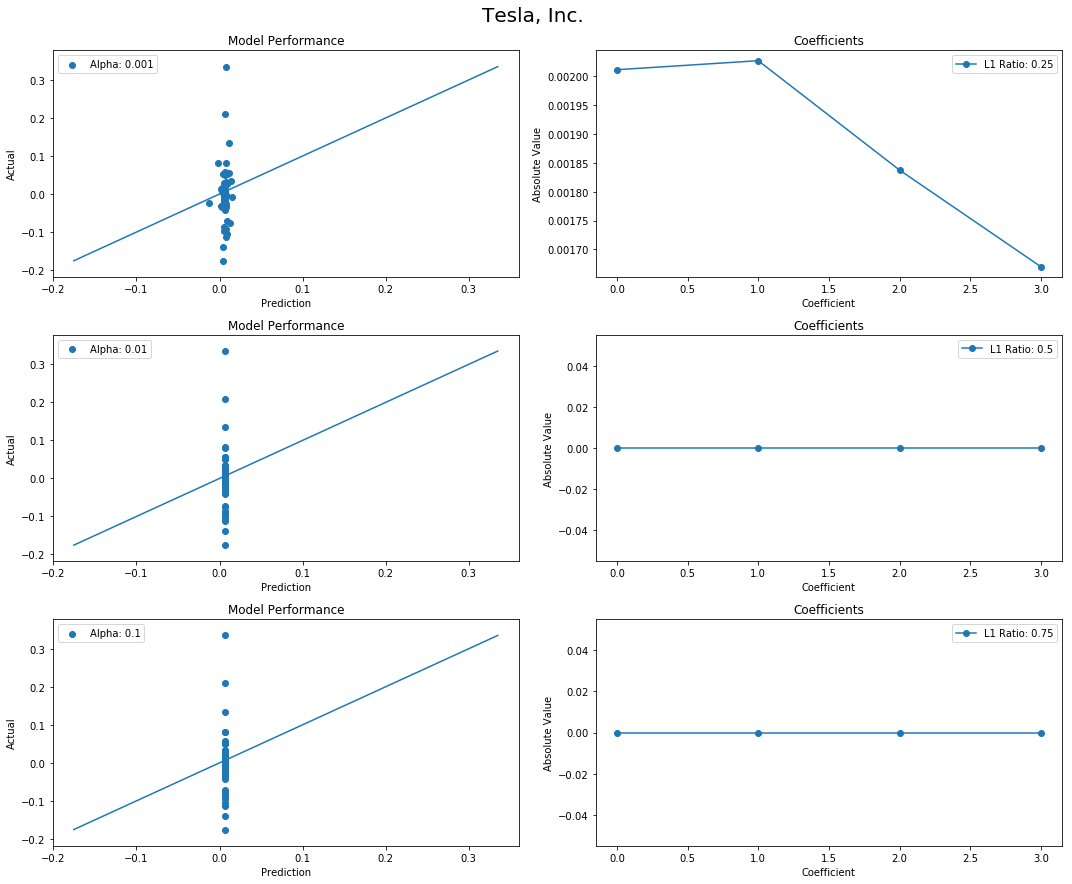

In [31]:
plot_elastic_net(ticker_dict['TSLA'],
                 tsla_features_train, tsla_target_train,
                 tsla_features_test, tsla_target_test,
                 'tesla_elastic_net.pdf')

Chaning the hyper-parameters has disappointingly little affect on the outcome. Even when changing the L1 ratio, the coefficients are very similar. With an L1 ratio of 0, going full Ridge, the model fails to converge.

### Market as a Whole  
There are two ways to do this:  
#### 1. Standard cross validation  
We will collect the data for every company into a dataframe for the whole market. Then perform standard cross-validation to tune parameters and then test the model on a validation set.  
  
  
#### 2. Remove a basket of test companies and train the model on the rest of the market.  
Pick five to ten companies that you are most interested in. Train your model, like in method one above, and then test of each company in your basket. See which most closely follows the market. 

### Method One
#### Function Prep

In [32]:
def split_and_scale(x, y):
    # Split Data
    test_size, state = 0.25, 42

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = state)
    
    # Scale Data
    ss = StandardScaler()
    x_train = ss.fit_transform(x_train)
    x_test  = ss.transform(x_test)
    
    return x_train, x_test, y_train, y_test

In [109]:
def grid_search(title, x_train, x_test, y_train, y_test, savefile, alphas=[1e-3, 1e-2, 1e-1], l1_ratios=[0.1, 0.2, 0.3], make_plots=True):
    # Build Model
    model = ElasticNet()
    parameters = {'alpha': alphas,
                  'l1_ratio': l1_ratios}
    grid = GridSearchCV(model, parameters, cv=5)
    
    # Fit Model
    grid.fit(x_train, y_train)
    
    # Best Model
    best_model = grid.best_estimator_
    alpha = best_model.alpha
    l1_ratio = best_model.l1_ratio
    predictions = best_model.predict(x_test)
    
    if make_plots:
        # Plot Results
        fig, ax_rows = plt.subplots(2, 1, figsize=(7, 8))
        fig.suptitle(title, fontsize=20, y=.96)

        ax_left, ax_right = ax_rows[0], ax_rows[1]
        plot_errors(predictions, y_test, ax_left, 'Alpha: '+str(alpha))
        plot_coefficients(best_model, ax_right, 'L1 Ratio: '+str(l1_ratio))
    
        plt.tight_layout(h_pad = 2.0)
        plt.subplots_adjust(top=0.88)
        plt.savefig(savefile)
    
    # Score
    score = best_model.score(x_test, y_test)
    
    return score, predictions

#### Entire Market

In [34]:
# Collect Data for entire market
market = pd.DataFrame()
for file in folder:
    df = load_df(file)
    df = clean_data(df)
    market = market.append(df)

In [35]:
market.shape

(8885, 20)

In [36]:
market_features = features(market)
market_target = market['adj_change']

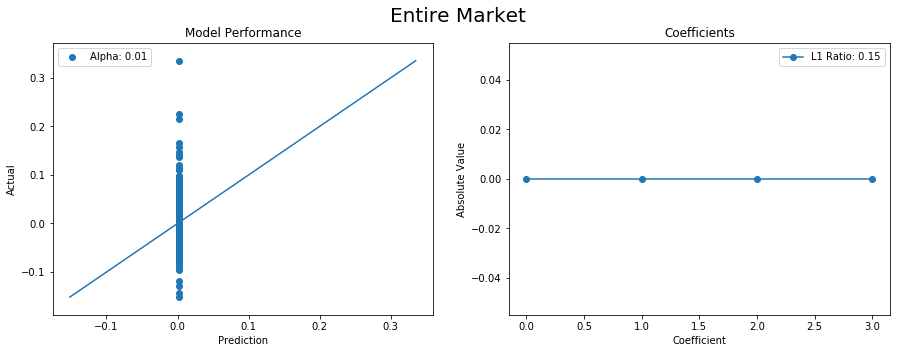

In [37]:
x_train, x_test, y_train, y_test = split_and_scale(market_features, market_target)
score, predictions = grid_search("Entire Market",
                                 x_train, x_test,
                                 y_train, y_test,
                                 'entire_market.pdf',
                                 l1_ratios=[0.05, 0.1, 0.15, 0.2, 0.25])

In [38]:
score

-0.00012605796785858381

In [39]:
np.mean(market_target)

0.0017029015435584473

This makes it clear that, market-wide, a linear regression model can do no better than just guessing the mean each time. In fact, that's exactly what it does.

In [40]:
set(predictions)

{0.00162924828380736}

### Method Two
#### Function Prep

In [41]:
def scale_data(x_train, x_val):
    # Scale Data
    ss = StandardScaler()
    x_train = ss.fit_transform(x_train)
    x_val   = ss.transform(x_val)
    
    return x_train, x_val

In [42]:
def choose_and_scale_data(chosen_company):
    x_val = basket[chosen_company]['features']
    y_val = basket[chosen_company]['target']
    x_train = rest_of_market_features
    y_train = rest_of_market_target
    
    x_train, x_val = scale_data(x_train, x_val)
    
    return x_train, x_val, y_train, y_val

In [103]:
def test_chosen_company(chosen_company, make_plots=True):
    x_train, x_val, y_train, y_val = choose_and_scale_data(chosen_company)
    score, _ = grid_search('         ' + ticker_dict[chosen_company], x_train, x_val, y_train, y_val, 'Chosen One.pdf', make_plots=make_plots)
    
    return score

#### Basket of Companies

In [44]:
basket_tickers = ['AMZN', 'SBUX', 'TSLA', 'COST', 'HAS', 'AAL', 'FOX', 'MAR', 'ADSK', 'ALXN']

In [45]:
for ticker in basket_tickers:
    print(ticker + ": "+ ticker_dict[ticker])

AMZN: Amazon.com, Inc.
SBUX: Starbucks Corporation
TSLA: Tesla, Inc. 
COST: Costco Wholesale Corporation
HAS: Hasbro, Inc.
AAL: American Airlines Group, Inc.
FOX: Twenty-First Century Fox, Inc.
MAR: Marriott International
ADSK: Autodesk, Inc.
ALXN: Alexion Pharmaceuticals, Inc.


In [46]:
# Basket of companies
basket = {}
for abbrev in basket_tickers:
    filename = abbrev + '.h5'
    basket[abbrev] = clean_data(load_df(filename))

In [47]:
for ticker, df in basket.items():
    basket[ticker] = {'features': features(df),
                      'target': df["adj_change"]}

In [48]:
basket.keys()

dict_keys(['AMZN', 'SBUX', 'TSLA', 'COST', 'HAS', 'AAL', 'FOX', 'MAR', 'ADSK', 'ALXN'])

Basket is now a dictionary of dictionaries. A company's ticker as key can access a dataframe of `features` or a dataframe of `targets`.

In [49]:
# Collect data for the rest of the market
rest_of_market = pd.DataFrame()
for abbrev, _ in companies:
    if abbrev not in basket_tickers:
        filename = abbrev + '.h5'
        df = clean_data(load_df(filename))
        rest_of_market = rest_of_market.append(df)

In [50]:
rest_of_market_features = features(rest_of_market)
rest_of_market_target   = rest_of_market['adj_change']

We do our parameter tuning via cross-validation on the rest of the market. They we validate on a particular company.

-0.00084400005270124367

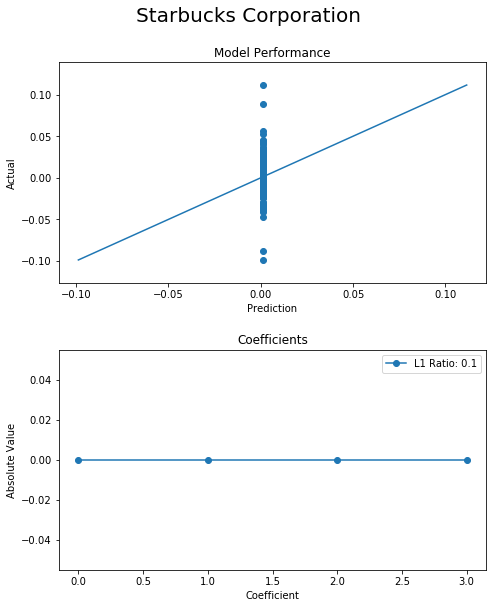

In [94]:
test_chosen_company('SBUX')

-0.0049877510747298182

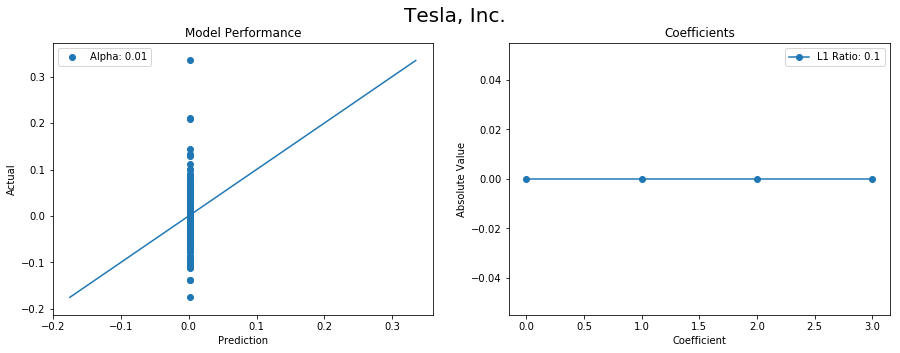

In [52]:
test_chosen_company('TSLA')

Which company's model is the best?

In [53]:
score_dict = {}
for ticker, _ in basket.items():
    try:
        score_dict[ticker] = test_chosen_company(ticker, make_plots=False)
    except:
        print(ticker)
        raise

In [54]:
for ticker in basket_tickers:
    print('R2: ' + str(round(score_dict[ticker], 4)))

R2: -0.0242
R2: -0.0008
R2: -0.005
R2: -0.0035
R2: -0.0117
R2: -0.0006
R2: -0.0666
R2: -0.0008
R2: -0.0007
R2: -0.0062


With an R^2 value of a whopping 0.004, our winner is COST, otehrwise known as Costco!

-0.0035218199305955267

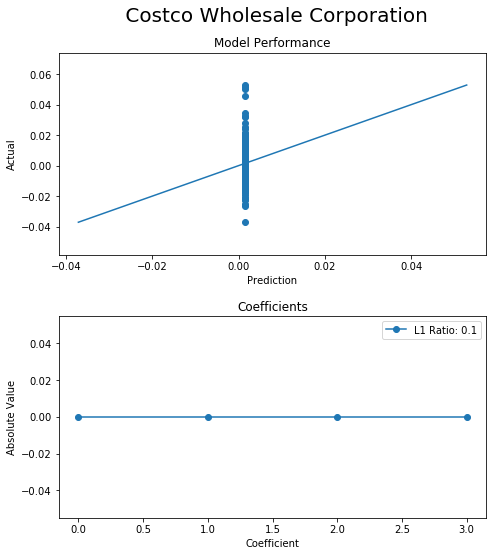

In [110]:
test_chosen_company('COST')

In [56]:
basket['AAL']['features'].columns

Index(['size_delta', 'minor_edit', 'non-minor_edit', 'search_interest'], dtype='object')

### Appendix

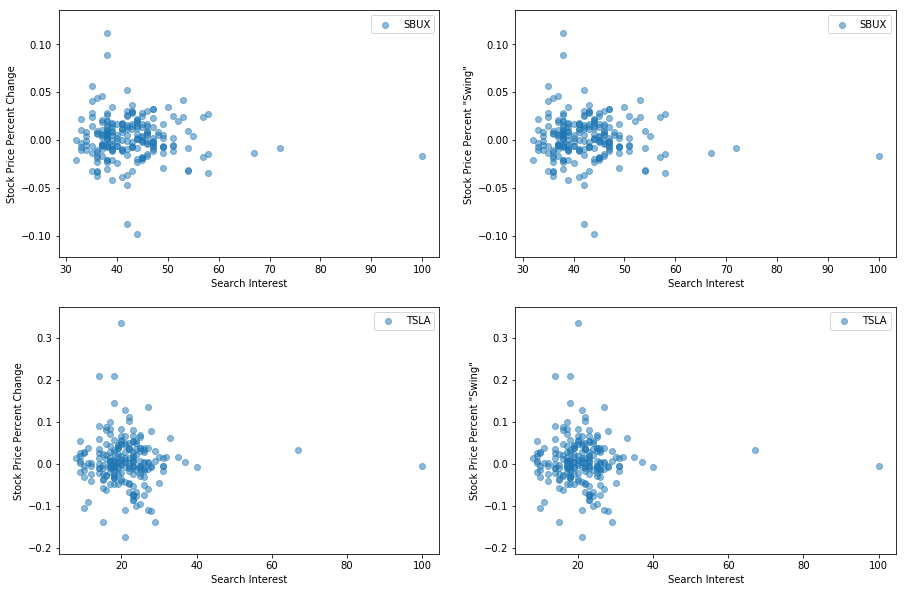

In [57]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.scatter(sbux_features['search_interest'], sbux_target, alpha=0.5, label='SBUX')
plt.xlabel('Search Interest')
plt.ylabel('Stock Price Percent Change')
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(sbux_features['search_interest'], sbux_target, alpha=0.5, label='SBUX')
plt.xlabel('Search Interest')
plt.ylabel('Stock Price Percent "Swing"')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(tsla_features['search_interest'], tsla_target, alpha=0.5, label='TSLA')
plt.xlabel('Search Interest')
plt.ylabel('Stock Price Percent Change')
plt.legend()

plt.subplot(2, 2, 4)
plt.scatter(tsla_features['search_interest'], tsla_target, alpha=0.5, label='TSLA')
plt.xlabel('Search Interest')
plt.ylabel('Stock Price Percent "Swing"')
plt.legend();

Relationship between trend data and Wikipedia data?

In [58]:
basket

{'AAL': {'features':             size_delta  minor_edit  non-minor_edit  search_interest
  2013-02-17      4101.0         0.0             6.0               23
  2013-02-24        17.0         1.0            10.0               26
  2013-03-03       201.0         1.0             5.0               29
  2013-03-10       -26.0         3.0             7.0               27
  2013-03-17       -15.0         0.0             1.0               20
  2013-03-24     -1888.0         0.0             2.0               24
  2013-03-31       352.0         2.0             2.0               18
  2013-05-19         0.0         0.0             2.0               15
  2013-07-21      2447.0         3.0             3.0               12
  2013-07-28        94.0         1.0             3.0               18
  2013-08-18       713.0         0.0             4.0               26
  2013-08-25       321.0         3.0             4.0               14
  2013-09-22      2913.0         8.0            12.0               15
 

In [59]:
num_edits = basket['AAL']['features']['minor_edit'] + basket['AAL']['features']['non-minor_edit']

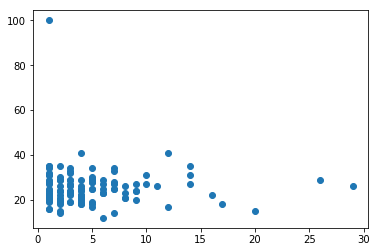

In [60]:
plt.scatter(num_edits, basket['AAL']['features']['search_interest'])

In [61]:
tickers = list(basket.keys())

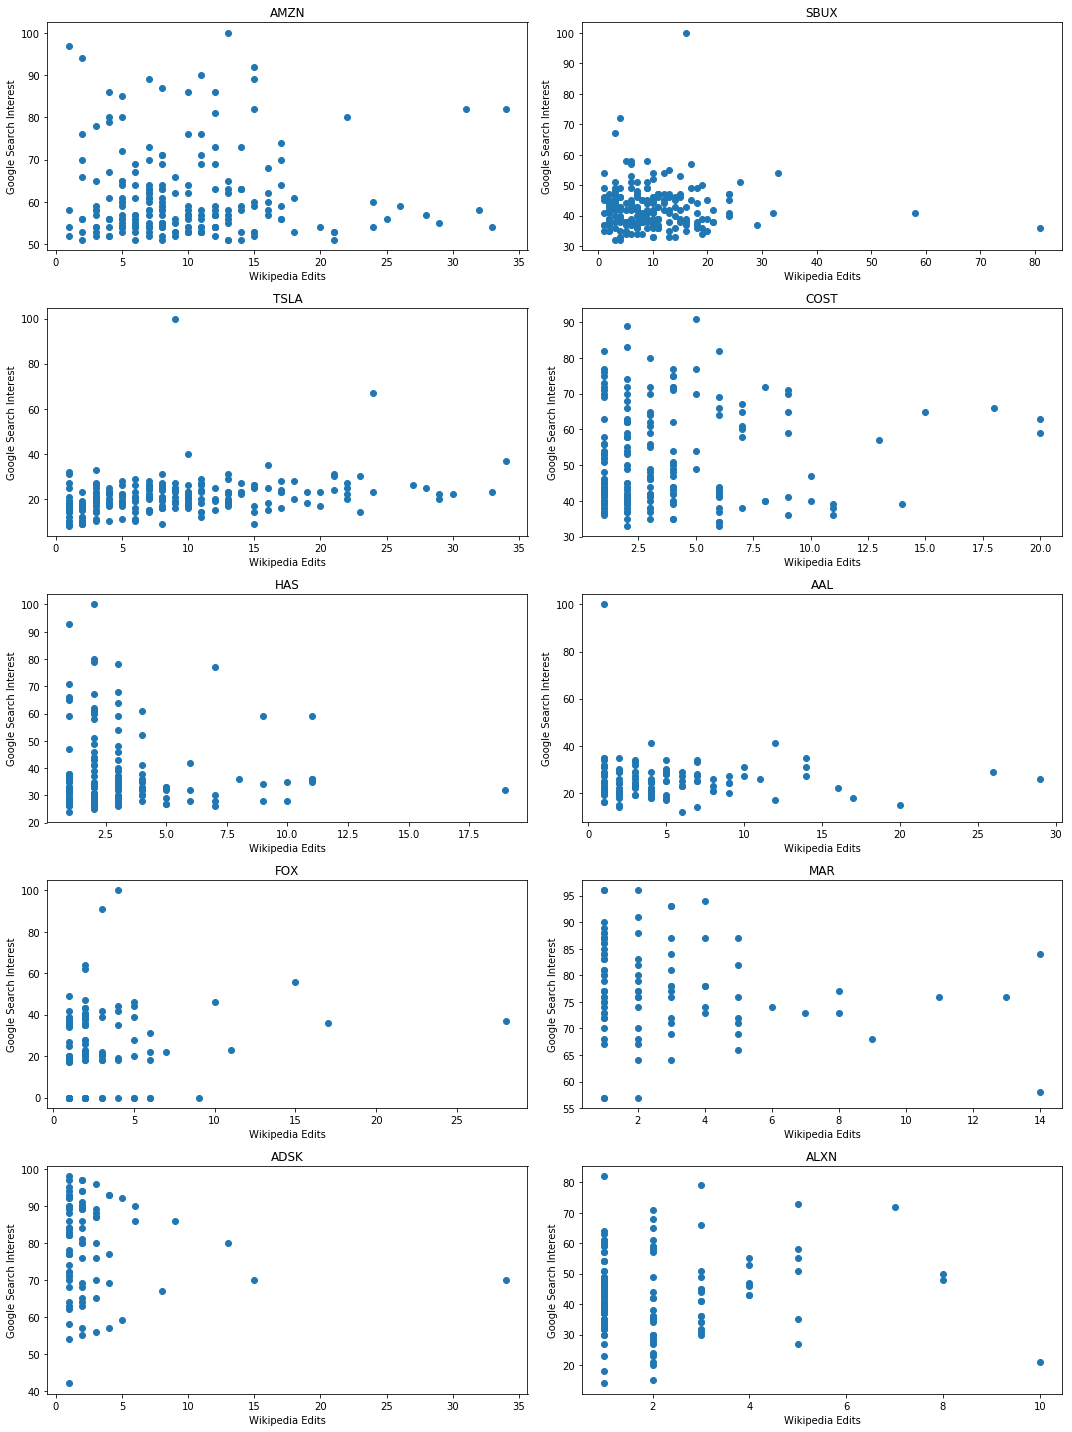

In [62]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for ticker, ax in zip(tickers, axes.reshape(-1)):
    num_edits = basket[ticker]['features']['minor_edit'] + basket[ticker]['features']['non-minor_edit']
    ax.scatter(num_edits, basket[ticker]['features']['search_interest'])
    
    ax.set_title(ticker)
    ax.set_xlabel("Wikipedia Edits")
    ax.set_ylabel("Google Search Interest")
    
plt.tight_layout()